# Part 1: ML Modeling for Unsupervised Anomaly Detection

## 🔹 Task Overview
### Developing unsupervised anomaly detection models to analyze a telecom network KPI dataset. The dataset contains:
- 60 days of daily measurements 
- 100 cellular network sites, each with 3–5 sectors
- 10 Key Performance Indicators (KPIs)
- There are no labeled anomalies, so the goal is to apply unsupervised learning techniques to identify anomalous behavior in the KPIs.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pywt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings("ignore")

#### Loding the data set 

In [2]:
df = pd.read_csv("Data\AD_data_10KPI.csv", parse_dates=["Date"]) # Update with actual path
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%y')
df = df.sort_values(by=['Sector_ID', 'Date']).reset_index(drop=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21060 entries, 0 to 21059
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   21060 non-null  datetime64[ns]
 1   Site_ID                21060 non-null  object        
 2   Sector_ID              21060 non-null  object        
 3   RSRP                   21060 non-null  float64       
 4   DL_Throughput          21060 non-null  float64       
 5   Call_Drop_Rate         21060 non-null  float64       
 6   RTT                    21060 non-null  float64       
 7   CPU_Utilization        21060 non-null  float64       
 8   Active_Users           21060 non-null  float64       
 9   SINR                   21060 non-null  float64       
 10  UL_Throughput          21060 non-null  float64       
 11  Handover_Success_Rate  21060 non-null  float64       
 12  Packet_Loss            21060 non-null  float64       
dtypes

# Data Pre-Processing

#### 🔹 KPI Data Type Conversion
-To ensure accurate numerical analysis, all KPI columns were explicitly converted to numeric data types. Any invalid entries (e.g., non-numeric characters or missing values) were coerced to NaN.

In [4]:
kpi_cols = ['RSRP', 'DL_Throughput', 'Call_Drop_Rate', 'RTT', 'CPU_Utilization',
            'Active_Users', 'SINR', 'UL_Throughput', 'Handover_Success_Rate', 'Packet_Loss']
df[kpi_cols] = df[kpi_cols].apply(pd.to_numeric, errors='coerce')

#### 🔹 Exploratory Statistics for KPI Distribution
- To understand the baseline characteristics of each KPI, summary statistics were computed before applying any anomaly detection or outlier removal. This helps identify natural variability and potential thresholds.

In [5]:
summary = []
for kpi in kpi_cols:
    kpi_data = df[kpi].dropna()
    orig_stats = kpi_data.describe()
    summary.append({
        "KPI": kpi,
        "Original Mean": orig_stats["mean"],
        "Original Std": orig_stats["std"],
        "Min": orig_stats["min"],
        "Max": orig_stats["max"]
    })
summary_df = pd.DataFrame(summary)
summary_df = summary_df.round(2)

print(summary_df)

                     KPI  Original Mean  Original Std      Min      Max
0                   RSRP         -97.38         49.15 -2976.94   273.44
1          DL_Throughput          56.17         37.74  -502.59   796.77
2         Call_Drop_Rate           2.93          2.34   -21.45    60.35
3                    RTT          26.40         21.82  -216.19   564.40
4        CPU_Utilization          52.78         28.96  -155.64   515.02
5           Active_Users         583.16        383.62 -6337.85  4489.94
6                   SINR          10.42         16.34  -284.74   216.15
7          UL_Throughput          29.95         26.00  -214.11  1172.52
8  Handover_Success_Rate          95.38         47.19 -2375.43  1187.06
9            Packet_Loss           1.72          1.59   -27.94    43.28


### 🔹 Domain-Informed KPI Bounds

- To improve the robustness of anomaly detection, domain-specific thresholds were defined for each KPI based on realistic operational ranges observed in cellular networks. 
- These bounds help filter implausible values and reduce the impact of extreme outliers before modeling.

Below is a breakdown of the threshold logic per KPI:

| KPI                      | Lower Bound       | Upper Bound Strategy   | Justification |
|--------------------------|-------------------|-------------------------|---------------|
| **RSRP**                 | -120 dBm          | 97th percentile         | Reference Signal Received Power typically ranges from -120 dBm (weak) to -60 dBm (strong). Values above the 97th percentile are rare and often reflect measurement noise. |
| **DL_Throughput**        | 0 Mbps            | 98th percentile         | Negative throughput is invalid. The 98th percentile cap excludes rare spikes due to short bursts or recording glitches. |
| **Call_Drop_Rate**       | 0%                | 98th percentile         | Call drops cannot be negative. Rates above the 98th percentile may represent localized issues or misreporting. |
| **RTT (Latency)**        | 0 ms              | 97th percentile         | Round Trip Time cannot be negative. Abnormally high RTTs above the 97th percentile likely indicate network congestion or errors. |
| **CPU_Utilization**      | 0%                | 100% (absolute cap)     | Utilization must lie within [0, 100]. Values beyond this range are invalid by definition. |
| **Active_Users**         | 0 users           | 98th percentile         | User count cannot be negative. Values above the 98th percentile may occur during special events or incorrect logging. |
| **SINR**                 | -10 dB            | 97th percentile         | Signal-to-Interference-plus-Noise Ratio (SINR) rarely falls below -10 dB. High outliers (97th+) may result from environmental reflections or hardware issues. |
| **UL_Throughput**        | 0 Mbps            | 98th percentile         | Same logic as DL throughput; negative values are invalid, and upper extremes are capped. |
| **Handover_Success_Rate**| 0%                | 98th percentile         | This metric ideally lies in [0,100]%. Upper-bound clipping helps filter reporting artifacts near 100%. |
| **Packet_Loss**          | 0%                | 97th percentile         | Packet loss cannot be negative. High outliers often suggest burst errors or logging issues. |


In [6]:
def define_kpi_bounds():
    """
    Define realistic bounds for each KPI based on telecom domain knowledge
    """
    kpi_bounds = {
        'RSRP': {'lower': -120, 'upper_percentile': 97},  # Signal strength (dBm)
        'DL_Throughput': {'lower': 0, 'upper_percentile': 98},  # Mbps
        'Call_Drop_Rate': {'lower': 0, 'upper_percentile': 98},  # Percentage
        'RTT': {'lower': 0, 'upper_percentile': 97},  # Milliseconds
        'CPU_Utilization': {'lower': 0, 'upper': 100},  # Percentage
        'Active_Users': {'lower': 0, 'upper_percentile': 98},  # Count
        'SINR': {'lower': -10, 'upper_percentile': 97},  # dB
        'UL_Throughput': {'lower': 0, 'upper_percentile': 98},  # Mbps
        'Handover_Success_Rate': {'lower': 0, 'upper_percentile': 98},  # Percentage
        'Packet_Loss': {'lower': 0, 'upper_percentile': 97}  # Percentage
    }
    return kpi_bounds

In [7]:
def remove_domain_outliers(df, kpi_bounds):
    """
    Remove KPI outliers based on domain-specific lower bounds and upper percentiles or fixed thresholds.
    """
    df_cleaned = df.copy()
    
    for kpi, bounds in kpi_bounds.items():
        if 'lower' in bounds:
            df_cleaned = df_cleaned[df_cleaned[kpi] >= bounds['lower']]
        
        if 'upper' in bounds:
            df_cleaned = df_cleaned[df_cleaned[kpi] <= bounds['upper']]
        
        elif 'upper_percentile' in bounds:
            upper_val = df_cleaned[kpi].quantile(bounds['upper_percentile'] / 100.0)
            df_cleaned = df_cleaned[df_cleaned[kpi] <= upper_val]

    return df_cleaned

kpi_bounds = define_kpi_bounds()
df_cleaned = remove_domain_outliers(df, kpi_bounds)
df_cleaned.to_csv('Data\KPI_data_cleaned.csv', index=False)

#### 🔹 Comparison of Original vs. Cleaned KPI Statistics

To quantify the impact of outlier removal and domain-bound filtering, descriptive statistics were computed for each KPI **before and after cleaning**.

For each KPI:
- Outliers were removed based on percentile thresholds and domain-informed bounds.
- The cleaned version shows reduced standard deviation and more realistic min/max values.

The table below summarizes the **mean**, **standard deviation**, **minimum**, and **maximum** values before and after cleaning:


In [8]:
summary = []

for kpi in kpi_cols:
    kpi_data = df[kpi].dropna()
    kpi_data_cleaned = df_cleaned[kpi].dropna()
    orig_stats = kpi_data.describe()
    cleaned_stats = kpi_data_cleaned.describe()
    summary.append({
        "KPI": kpi,
        "Original Mean": orig_stats["mean"],
        "Cleaned Mean": cleaned_stats["mean"],
        "Original Std": orig_stats["std"],
        "Cleaned Std": cleaned_stats["std"],
        "Original Min": orig_stats["min"],
        "cleaned_Min": cleaned_stats["min"],
        "Original Max": orig_stats["max"],
        "cleaned_Max": cleaned_stats["max"]
    })
summary_df = pd.DataFrame(summary)
summary_df = summary_df.round(2)
print(summary_df)

                     KPI  Original Mean  Cleaned Mean  Original Std  \
0                   RSRP         -97.38        -95.14         49.15   
1          DL_Throughput          56.17         54.45         37.74   
2         Call_Drop_Rate           2.93          2.77          2.34   
3                    RTT          26.40         25.08         21.82   
4        CPU_Utilization          52.78         50.55         28.96   
5           Active_Users         583.16        562.65        383.62   
6                   SINR          10.42         10.05         16.34   
7          UL_Throughput          29.95         28.29         26.00   
8  Handover_Success_Rate          95.38         91.40         47.19   
9            Packet_Loss           1.72          1.62          1.59   

   Cleaned Std  Original Min  cleaned_Min  Original Max  cleaned_Max  
0        15.12      -2976.94      -120.00        273.44       -70.00  
1        27.14       -502.59         0.12        796.77       103.91  
2    

### 🔹 Multi-KPI Distribution Analysis (Post-Cleaning)

To visually inspect the cleaned KPI values across the entire dataset, a **facet grid of histograms with KDE overlays** was plotted for all 10 KPIs.

This provides insight into:
- The overall distribution of each KPI after preprocessing
- Presence of skewness or multimodal behavior
- Comparison of scale and spread across metrics


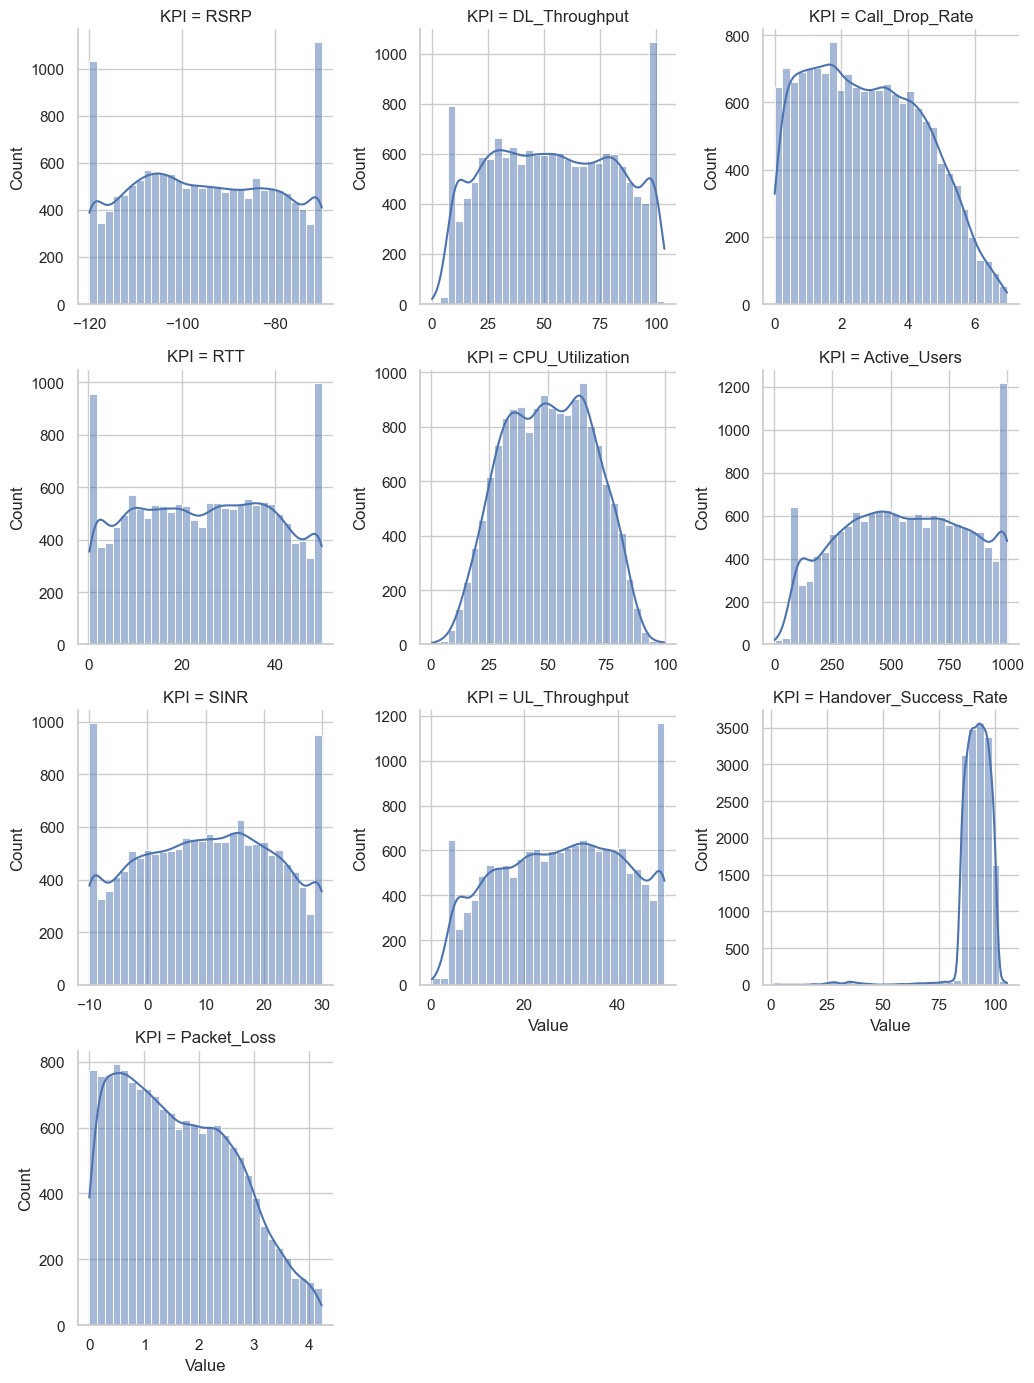

In [9]:
# Melt dataframe for multi-KPI distribution plots
df_melted = df_cleaned.melt(id_vars=['Date', 'Site_ID', 'Sector_ID'], value_vars=kpi_cols,
                    var_name='KPI', value_name='Value')
sns.set(style="whitegrid")
g = sns.FacetGrid(df_melted, col="KPI", col_wrap=3, sharex=False, sharey=False, height=3.5)
g.map(sns.histplot, "Value", bins=30, kde=True)

plt.tight_layout()
plt.show()

### 🔹 Anomaly Detection Models: DWT-MLEAD and Isolation Forest

To detect unsupervised anomalies in the telecom KPI time series data, we selected two complementary models based on the benchmarking study:

> **Schmidl, S., Wenig, P., & Papenbrock, T. (2022). Anomaly Detection in Time Series: A Comprehensive Evaluation**  
> *Hasso Plattner Institute, University of Potsdam; Philipps University of Marburg*

This paper evaluates a wide spectrum of time-series anomaly detection techniques and identifies strong candidates across univariate and multivariate domains. Two models from their study were used in my analysis:

---

#### 📘 1. **DWT-MLEAD (Discrete Wavelet Transform - Multilevel Event-based Anomaly Detection)**

- **Type**: Univariate time series
- **Method**:
  - Applies a multi-level Discrete Wavelet Transform (DWT) using Daubechies wavelets (e.g., `'db4'`)
  - Reconstructs the baseline signal after soft-thresholding the detail coefficients
  - Computes residuals between original and reconstructed signal
  - Flags anomalies where the **z-score of residuals** exceeds a defined threshold
- **Strengths**:
  - Detects both short-term bursts and longer trend shifts
  - Highly sensitive to localized structural changes
  - Suitable for noisy KPIs like `DL_Throughput`, `RTT`, and `SINR`

---

#### 📘 2. **Isolation Forest (IF)**

- **Type**: Univariate or multivariate feature-based
- **Method**:
  - Constructs random decision trees to isolate data points
  - Anomalies are points that are isolated in fewer splits (i.e., lie in sparse regions)
  - Uses a contamination parameter (e.g., `0.01`) to define expected anomaly proportion
- **Strengths**:
  - Efficient on large datasets
  - Model-agnostic and handles mixed distributions
  - Well-suited for more stable KPIs like `CPU_Utilization`, `Packet_Loss`, and `Call_Drop_Rate`

---

Both models were chosen for their **strong empirical performance** and **interpretability** in the referenced evaluation paper. This dual-model strategy allows us to tailor anomaly detection to the specific statistical characteristics of each KPI.


In [10]:
def dwt_mlead_anomaly_detection(series, wavelet='db4', level=3, threshold_factor=2):
    scaler = MinMaxScaler()
    scaled_series = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()
    coeffs = pywt.wavedec(scaled_series, wavelet, level=level)
    detail_coeffs = np.hstack(coeffs[1:])
    threshold = threshold_factor * np.std(detail_coeffs)
    thresholded_coeffs = [coeffs[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    reconstructed = pywt.waverec(thresholded_coeffs, wavelet)
    reconstructed = reconstructed[:len(scaled_series)]
    residual = scaled_series - reconstructed
    residual_z = zscore(residual)
    anomaly_indices = np.where(np.abs(residual_z) > threshold_factor)[0]
    return anomaly_indices, residual_z

### 🔹 Method 1: KPI Grouping and Model Selection Rationale

To tailor the anomaly detection process to the statistical behavior of each KPI, we divided the 10 network metrics into two groups — each assigned a specific unsupervised model. This grouping is based on signal characteristics such as **noise level**, **trend stability**, and **expected anomaly patterns**, as supported by the research study from Schmidl et al.

---

#### 📘 Group 1: KPIs Assigned to DWT-MLEAD
dwt_kpis = ['DL_Throughput', 'UL_Throughput', 'RTT', 'SINR', 'RSRP']

- These KPIs exhibit continuous, high-variance time series behavior with frequent short-term fluctuations or localized spikes.
- They benefit from wavelet-based decomposition, which can isolate abrupt changes across multiple frequency bands.
- DWT-MLEAD effectively captures structural anomalies such as:
  - Sudden drops in throughput (DL_Throughput, UL_Throughput)
  - Latency spikes (RTT)
  - Signal degradation (RSRP, SINR)

#### 📘 Group 2: KPIs Assigned to Isolation Forest
if_kpis = ['CPU_Utilization', 'Handover_Success_Rate', 'Call_Drop_Rate', 'Packet_Loss', 'Active_Users']
- These KPIs are generally bounded, categorical, or smoother in behavior over time.
- Anomalies here may not show sharp fluctuations but can be isolated in feature space (e.g., unusual utilization or packet loss rates).
- Isolation Forest excels in capturing point anomalies that deviate from typical operational envelopes:
  - CPU overuse (CPU_Utilization)
  - Sudden call drops or packet loss (Call_Drop_Rate, Packet_Loss)
  - Unusual sector congestion (Active_Users)
  - Low handover performance (Handover_Success_Rate)




In [11]:
# KPI groups
dwt_kpis = ['DL_Throughput', 'UL_Throughput', 'RTT', 'SINR', 'RSRP']
if_kpis = ['CPU_Utilization', 'Handover_Success_Rate', 'Call_Drop_Rate', 'Packet_Loss', 'Active_Users']


### 🔹 Anomaly Detection Execution: DWT-MLEAD and Isolation Forest

For each KPI and sector, we applied the assigned anomaly detection method using the grouping defined earlier. The detection was performed individually per sector to preserve temporal locality and allow KPI-specific tuning.

---


In [12]:
dwt_anomalies = []
if_anomalies = []

# Apply DWT-MLEAD
for kpi in dwt_kpis:
    for sector_id in df_cleaned['Sector_ID'].unique():
        sector_df = df_cleaned[df_cleaned['Sector_ID'] == sector_id].sort_values(by='Date')
        if len(sector_df) < 10 or kpi not in sector_df:
            continue
        try:
            anomalies, _ = dwt_mlead_anomaly_detection(sector_df[kpi], threshold_factor=2.5)
            for idx in anomalies:
                dwt_anomalies.append({
                    'KPI': kpi,
                    'Site_ID': sector_df.iloc[idx]['Site_ID'],
                    'Sector_ID': sector_id,
                    'Date': sector_df.iloc[idx]['Date'],
                    kpi: sector_df.iloc[idx][kpi]
                })
        except:
            continue

# Apply Isolation Forest
for kpi in if_kpis:
    for sector_id in df_cleaned['Sector_ID'].unique():
        sector_df = df_cleaned[df_cleaned['Sector_ID'] == sector_id].sort_values(by='Date')
        if len(sector_df) < 10 or kpi not in sector_df:
            continue
        try:
            valid_values = sector_df[kpi].dropna().values.reshape(-1, 1)
            model = IsolationForest(n_estimators=100, contamination=0.03, random_state=1024)
            preds = model.fit_predict(valid_values)
            anomaly_indices = np.where(preds == -1)[0]
            for idx in anomaly_indices:
                if_anomalies.append({
                    'KPI': kpi,
                    'Site_ID': sector_df.iloc[idx]['Site_ID'],
                    'Sector_ID': sector_id,
                    'Date': sector_df.iloc[idx]['Date'],
                    kpi: sector_df.iloc[idx][kpi]
                })
        except:
            continue

# Convert to DataFrames
df_dwt = pd.DataFrame(dwt_anomalies)
df_if = pd.DataFrame(if_anomalies)

In [13]:
print(df_if)
df_if.to_csv('Data\df_if.csv', index=False)
print(df_dwt)
df_if.to_csv('Data\df_dwt.csv', index=False)

                  KPI   Site_ID          Sector_ID       Date  \
0     CPU_Utilization  SITE_001  SITE_001_SECTOR_A 2024-01-07   
1     CPU_Utilization  SITE_001  SITE_001_SECTOR_A 2024-01-10   
2     CPU_Utilization  SITE_001  SITE_001_SECTOR_B 2024-02-06   
3     CPU_Utilization  SITE_001  SITE_001_SECTOR_B 2024-02-14   
4     CPU_Utilization  SITE_001  SITE_001_SECTOR_C 2024-01-27   
...               ...       ...                ...        ...   
3327     Active_Users  SITE_099  SITE_099_SECTOR_D 2024-01-10   
3328     Active_Users  SITE_099  SITE_099_SECTOR_D 2024-01-18   
3329     Active_Users  SITE_100  SITE_100_SECTOR_A 2024-01-03   
3330     Active_Users  SITE_100  SITE_100_SECTOR_A 2024-02-17   
3331     Active_Users  SITE_100  SITE_100_SECTOR_B 2024-02-24   

      CPU_Utilization  Handover_Success_Rate  Call_Drop_Rate  Packet_Loss  \
0           17.748526                    NaN             NaN          NaN   
1           74.027669                    NaN             NaN     

### 🔹 Method 2: Ensemble-Based Anomaly Detection (Voting Mechanism)
- To improve anomaly detection precision and reduce false positives, we implemented an ensemble approach by combining two unsupervised methods: DWT-MLEAD and Isolation Forest. This voting-based method considers a data point as anomalous only if both models agree.

✅ Approach:
For each KPI and each sector:
- Apply DWT-MLEAD to detect temporal anomalies in the KPI time series.
- Apply Isolation Forest to capture point anomalies based on statistical deviation.
- Identify common anomaly indices that are flagged by both models.
- Retain only those anomalies as ensemble-detected anomalies.

In [14]:
ensemble_anomalies = []

for kpi in kpi_cols:
    for sector_id in df_cleaned['Sector_ID'].unique():
        sector_df = df_cleaned[df_cleaned['Sector_ID'] == sector_id].sort_values(by='Date')
        if len(sector_df) < 10 or kpi not in sector_df:
            continue
        try:
            dwt_indices, _ = dwt_mlead_anomaly_detection(sector_df[kpi], threshold_factor=2)
        except:
            dwt_indices = []
        try:
            valid_values = sector_df[kpi].dropna().values.reshape(-1, 1)
            model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
            preds = model.fit_predict(valid_values)
            if_indices = np.where(preds == -1)[0]
        except:
            if_indices = []

        # --- Combine with Voting ---
        common_indices = set(dwt_indices).intersection(if_indices)

        for idx in common_indices:
            ensemble_anomalies.append({
                'KPI': kpi,
                'Site_ID': sector_df.iloc[idx]['Site_ID'],
                'Sector_ID': sector_id,
                'Date': sector_df.iloc[idx]['Date'],
                kpi: sector_df.iloc[idx][kpi]
            })

df_ensemble = pd.DataFrame(ensemble_anomalies)

In [15]:
print(df_ensemble)
df_ensemble.to_csv('Data\df_ensemble.csv', index=False)

              KPI   Site_ID          Sector_ID       Date        RSRP  \
0            RSRP  SITE_001  SITE_001_SECTOR_B 2024-02-11 -111.528321   
1            RSRP  SITE_001  SITE_001_SECTOR_C 2024-01-09 -108.059156   
2            RSRP  SITE_001  SITE_001_SECTOR_D 2024-02-06 -104.438432   
3            RSRP  SITE_002  SITE_002_SECTOR_A 2024-01-23  -96.736647   
4            RSRP  SITE_002  SITE_002_SECTOR_A 2024-01-24  -95.919319   
...           ...       ...                ...        ...         ...   
2282  Packet_Loss  SITE_098  SITE_098_SECTOR_A 2024-01-21         NaN   
2283  Packet_Loss  SITE_098  SITE_098_SECTOR_A 2024-01-27         NaN   
2284  Packet_Loss  SITE_099  SITE_099_SECTOR_B 2024-01-23         NaN   
2285  Packet_Loss  SITE_100  SITE_100_SECTOR_A 2024-01-07         NaN   
2286  Packet_Loss  SITE_100  SITE_100_SECTOR_B 2024-01-15         NaN   

      DL_Throughput  Call_Drop_Rate  RTT  CPU_Utilization  Active_Users  SINR  \
0               NaN             NaN  NaN  

### 🔹 Anomaly Visualization for Performance Insight

- To qualitatively assess the effectiveness of the anomaly detection models, we visualized KPI trends and corresponding detected anomalies for a representative sector
#### Purpose of This Visualization
- Confirms anomaly locations visually align with abnormal spikes, dips, or outliers.
- Separates true signal variations from noise, giving interpretability to model decisions.
- Provides performance intuition in the absence of labeled ground truth.
- Demonstrates model appropriateness per KPI: wavelet-based vs. tree-based isolation.


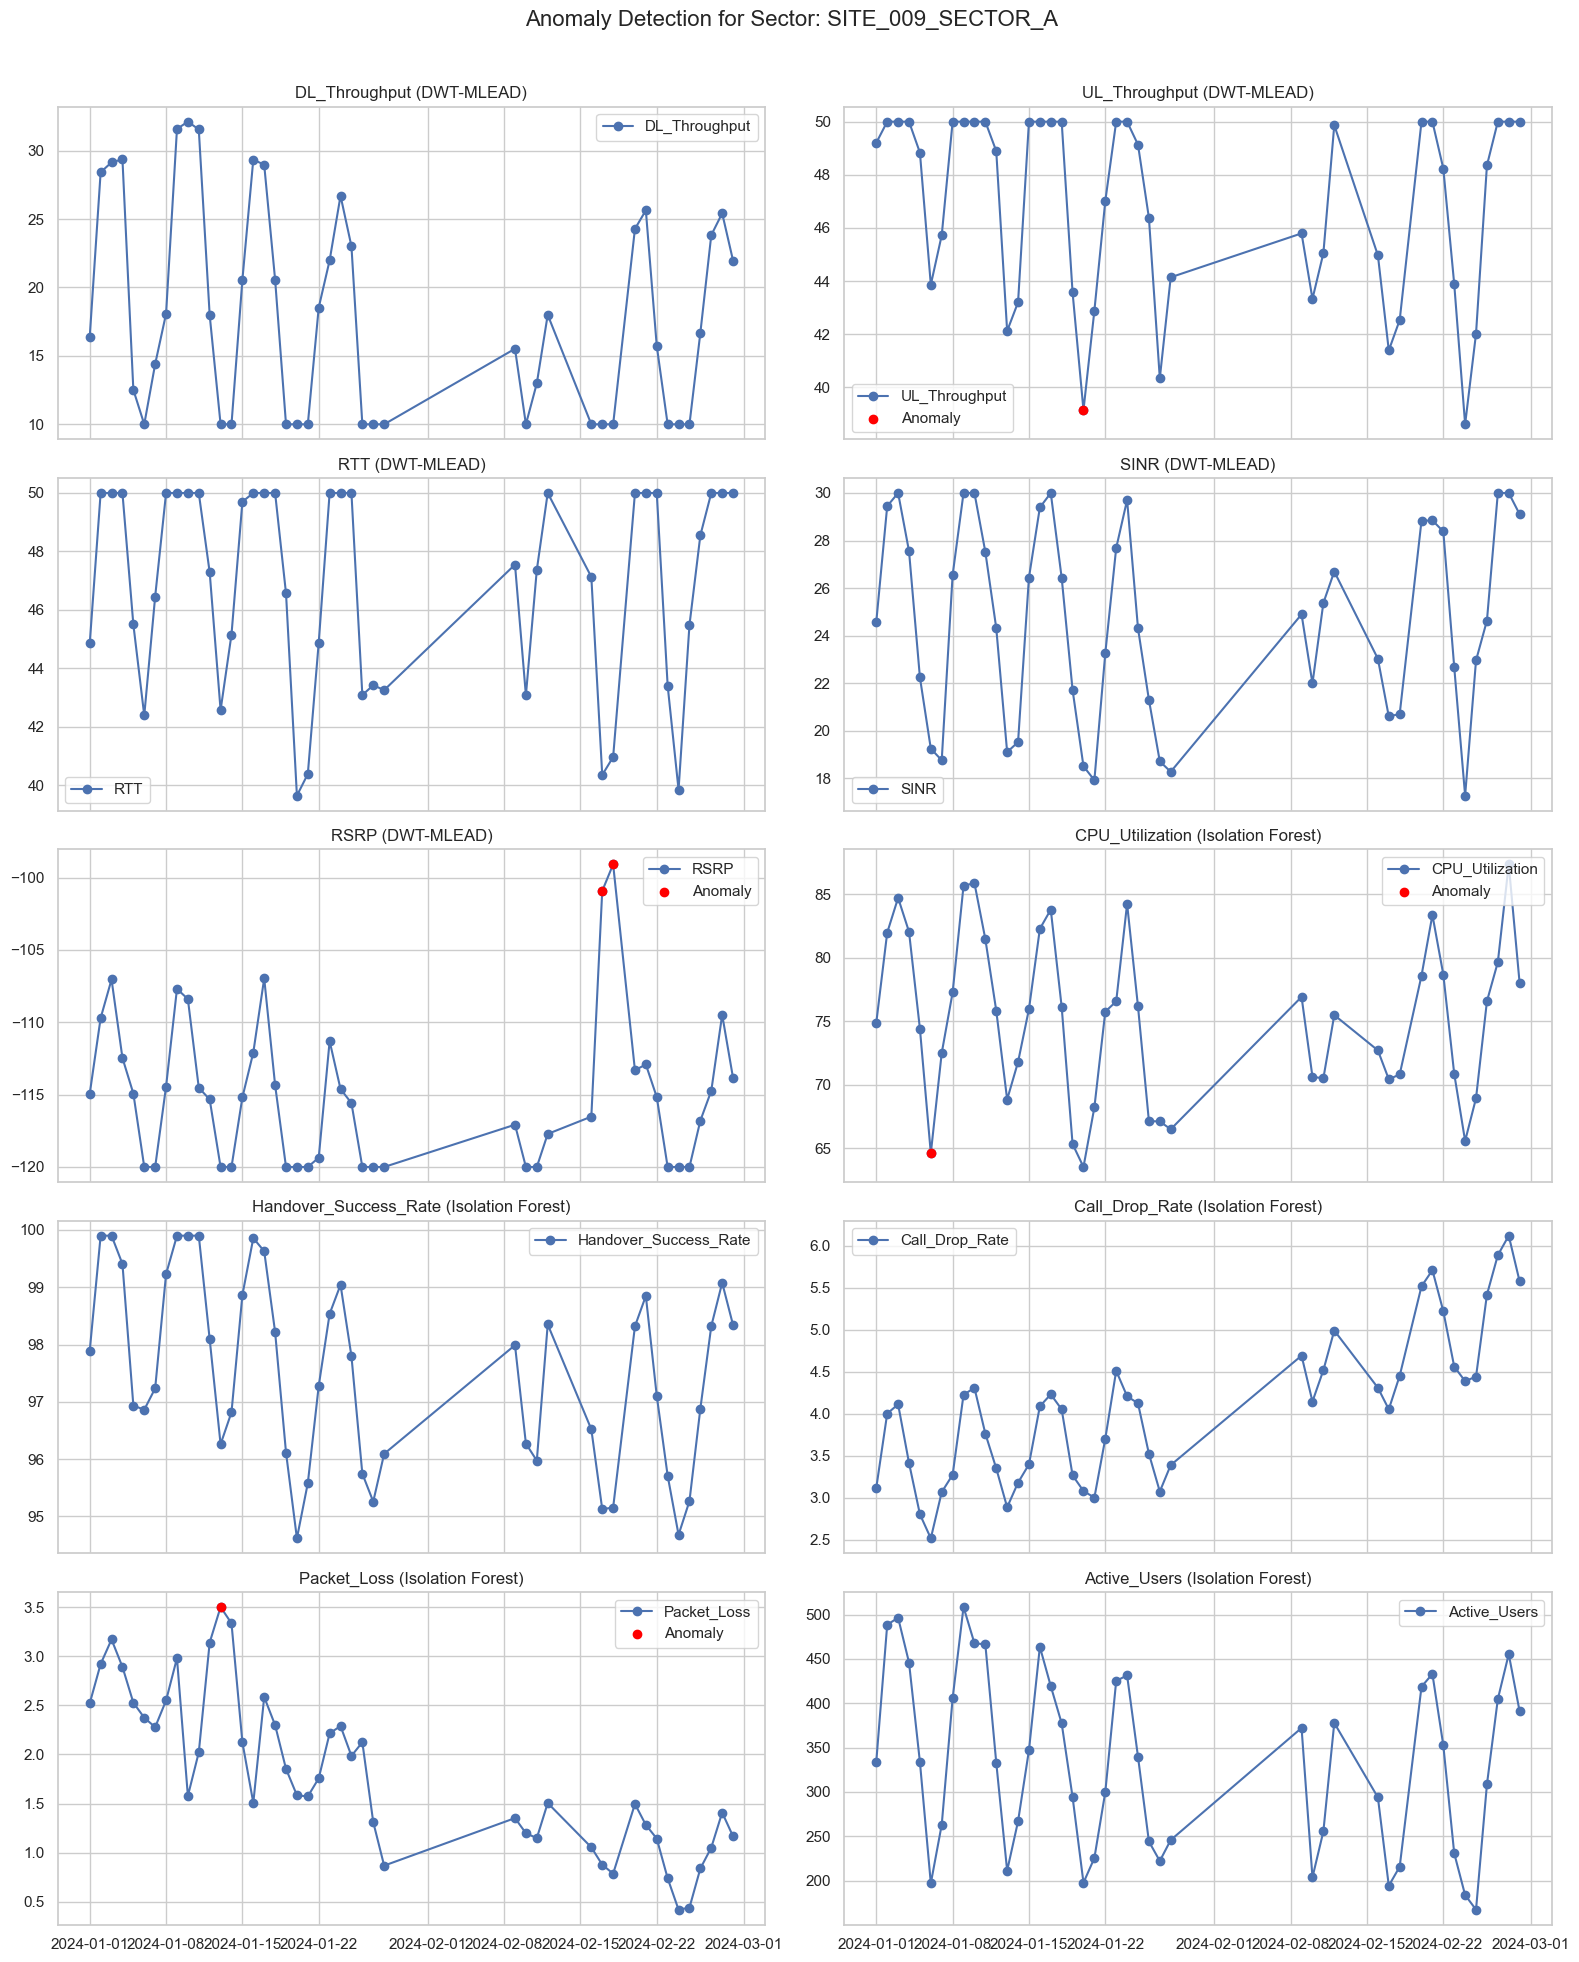

In [16]:
sector_id = 'SITE_009_SECTOR_A'
df_sector = df_cleaned[df_cleaned['Sector_ID'] == sector_id].sort_values('Date')

df_dwt_sector = df_ensemble[df_ensemble['Sector_ID'] == sector_id]
df_if_sector = df_ensemble[df_ensemble['Sector_ID'] == sector_id]

fig, axes = plt.subplots(5, 2, figsize=(16, 20), sharex=True)
axes = axes.flatten()
for i, kpi in enumerate(dwt_kpis):
    ax = axes[i]
    ax.plot(df_sector['Date'], df_sector[kpi], label=kpi, marker='o')
    anomalies = df_dwt_sector[df_dwt_sector['KPI'] == kpi]
    if not anomalies.empty:
        ax.scatter(anomalies['Date'], anomalies[kpi], color='red', label='Anomaly', zorder=5)
    ax.set_title(f"{kpi} (DWT-MLEAD)")
    ax.legend()
    ax.grid(True)
for i, kpi in enumerate(if_kpis, start=len(dwt_kpis)):
    ax = axes[i]
    ax.plot(df_sector['Date'], df_sector[kpi], label=kpi, marker='o')
    anomalies = df_if_sector[df_if_sector['KPI'] == kpi]
    if not anomalies.empty:
        ax.scatter(anomalies['Date'], anomalies[kpi], color='red', label='Anomaly', zorder=5)
    ax.set_title(f"{kpi} (Isolation Forest)")
    ax.legend()
    ax.grid(True)
plt.suptitle(f"Anomaly Detection for Sector: {sector_id}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### 🔹 Anomaly Rate Summary by KPI and Detection Method

To evaluate the overall effectiveness and sensitivity of the anomaly detection models across the entire dataset, we computed the **anomaly rate** per KPI. This metric captures how frequently each model flagged data points as anomalous.

#### 📌 Methodology:
For each KPI, we recorded:
- **Total Points**: Number of valid (non-NaN) entries in `df_cleaned`
- **Anomaly Count**: Number of anomalies flagged in either `df_dwt` or `df_if`
- **Anomaly Rate** = (Anomaly Count) / (Total Points)


In [17]:
kpi_counts = df.groupby('Sector_ID').size().reset_index(name='count')
sector_counts = kpi_counts.set_index('Sector_ID')['count'].to_dict()
anomaly_rates = []

for kpi in dwt_kpis:
    total_points = df_cleaned[kpi].count()
    anomaly_points = df_dwt[df_dwt['KPI'] == kpi].shape[0]
    anomaly_rate = anomaly_points / total_points if total_points > 0 else 0
    anomaly_rates.append({
        "KPI": kpi,
        "Method": "DWT-MLEAD",
        "Anomaly Count": anomaly_points,
        "Total Points": total_points,
        "Anomaly Rate": round(anomaly_rate, 4)
    })

for kpi in if_kpis:
    total_points = df_cleaned[kpi].count()
    anomaly_points = df_if[df_if['KPI'] == kpi].shape[0]
    anomaly_rate = anomaly_points / total_points if total_points > 0 else 0
    anomaly_rates.append({
        "KPI": kpi,
        "Method": "Isolation Forest",
        "Anomaly Count": anomaly_points,
        "Total Points": total_points,
        "Anomaly Rate": round(anomaly_rate, 4)
    })

df_anomaly_summary = pd.DataFrame(anomaly_rates)
print(df_anomaly_summary)

                     KPI            Method  Anomaly Count  Total Points  \
0          DL_Throughput         DWT-MLEAD            109         15655   
1          UL_Throughput         DWT-MLEAD            130         15655   
2                    RTT         DWT-MLEAD            110         15655   
3                   SINR         DWT-MLEAD             73         15655   
4                   RSRP         DWT-MLEAD             54         15655   
5        CPU_Utilization  Isolation Forest            670         15655   
6  Handover_Success_Rate  Isolation Forest            661         15655   
7         Call_Drop_Rate  Isolation Forest            669         15655   
8            Packet_Loss  Isolation Forest            670         15655   
9           Active_Users  Isolation Forest            662         15655   

   Anomaly Rate  
0        0.0070  
1        0.0083  
2        0.0070  
3        0.0047  
4        0.0034  
5        0.0428  
6        0.0422  
7        0.0427  
8        0.0

# Thank You!